In [ ]:
import torch
import torchvision
from torchvision.datasets.utils import download_and_extract_archive

# Good library for various image transformations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
from PIL import Image
import numpy as np

from tqdm import tqdm

from IPython import display
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Some Configuration:

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_EPOCHS = 500
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
LAMBDA_L1 = 100
LOAD_MODEL = True #False
SAVE_MODEL = True
CHECKPOINT_GEN = "/content/drive/MyDrive/Colab Notebooks/Honours/Untitled Folder/gen.pth.tar"
CHECKPOINT_DISC = "/content/drive/MyDrive/Colab Notebooks/Honours/Untitled Folder/disc.pth.tar"

both_transform = A.Compose(
    [A.Resize(width=256, height=256)], 
    additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2()
    ],
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2()
    ],
)

In [ ]:
print(DEVICE)

cuda


### Getting Map Dataset:
For training the model, we would be using the same dataset as used by the pix2pix authors, which is publicly availabe.

*   Dataset Url : http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
*   Dataset Size : 240 MB

In [ ]:
dataset_name = "maps"
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

# Downloading and extracting the dataset
download_and_extract_archive(_URL, download_root='../', extract_root='/content/drive/MyDrive/Colab Notebooks/Honours/Untitled Folder/', remove_finished=True)

  0%|          | 0/250242400 [00:00<?, ?it/s]

Extracting ../maps.tar.gz to /content/drive/MyDrive/Colab Notebooks/Honours/Untitled Folder/


After extracting the dataset we will be loading training dataset from the maps folder.

In [ ]:
# Defining the dataset loader function
class MapDatasetLoader(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.files = os.listdir(self.root_dir)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_file = self.files[idx]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_img = image[:, :600, :]
        target_img = image[:, 600:, :]

        augmented = both_transform(image=input_img, image0=target_img)
        input_img, target_img = augmented["image"], augmented["image0"]
        input_img = transform_only_input(image=input_img)["image"]
        target_img = transform_only_mask(image=target_img)["image"]

        return input_img, target_img
        

In [ ]:
# Loading training dataset
# Replace the path with the directory where you have extracted the dataset
data_path = '/content/drive/MyDrive/Colab Notebooks/Honours/Untitled Folder/maps/train'
dataset = MapDatasetLoader(data_path)
print('Number of training examples:', len(dataset))

Number of training examples: 1096


Plotting a random image from the dataset to see how the images look like.

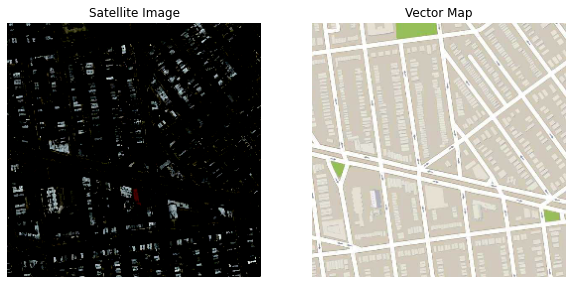

In [ ]:
(satellite, map) = dataset[0]
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Satellite Image')
plt.imshow(satellite.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(map.permute(1, 2, 0))
plt.axis('off')
plt.title('Vector Map')
plt.show()

### Some Utility Functions:

In [ ]:
def save_checkpoint(model, optimizer, filename = 'my_checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print('=> Loading Checkpoint')
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    # Update learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def save_example(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        # Remove Normalization
        y_fake = y_fake * 0.5 + 0.5
        torchvision.utils.save_image(y_fake, f'/content/drive/MyDrive/Colab Notebooks/Honours/Untitled Folder/{folder}/generated_{epoch}.png')
        torchvision.utils.save_image(x * 0.5 + 0.5, f'/content/drive/MyDrive/Colab Notebooks/Honours/Untitled Folder/{folder}/real_{epoch}.png')
        if epoch == 0 or epoch == NUM_EPOCHS:
            torchvision.utils.save_image(y * 0.5 + 0.5, f'/content/drive/MyDrive/Colab Notebooks/Honours/Untitled Folder/{folder}/target_{epoch}.png')
    gen.train()

### Some Important Components For GAN Architecture:

In [ ]:
class Block(torch.nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode='reflect') 
            if down 
            else torch.nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU() if act == 'relu' else torch.nn.LeakyReLU(0.2)
        )
        self.use_dropout = use_dropout
        self.dropout = torch.nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode='reflect'),
            torch.nn.LeakyReLU(0.2)
        ) # 128
        self.down1 = Block(features, features * 2, down=True, use_dropout=False, act='leaky') # 64
        self.down2 = Block(features * 2, features * 4, down=True, use_dropout=False, act='leaky') # 32
        self.down3 = Block(features * 4, features * 8, down=True, use_dropout=False, act='leaky') # 16
        self.down4 = Block(features * 8, features * 8, down=True, use_dropout=False, act='leaky') # 8
        self.down5 = Block(features * 8, features * 8, down=True, use_dropout=False, act='leaky') # 4
        self.down6 = Block(features * 8, features * 8, down=True, use_dropout=False, act='leaky') # 2

        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(features * 8, features * 8, 4, 2, 1, padding_mode='reflect'), # 1
        )

        self.up1 = Block(features * 8, features * 8, down=False, use_dropout=True, act='relu') # 4
        self.up2 = Block(features * 8 * 2, features * 8, down=False, use_dropout=True, act='relu') # 8
        self.up3 = Block(features * 8 * 2, features * 8, down=False, use_dropout=True, act='relu') # 16
        self.up4 = Block(features * 8 * 2, features * 8, down=False, use_dropout=False, act='relu') # 32
        self.up5 = Block(features * 8 * 2, features * 4, down=False, use_dropout=False, act='relu') # 64
        self.up6 = Block(features * 4 * 2, features * 2, down=False, use_dropout=False, act='relu') # 128
        self.up7 = Block(features * 2 * 2, features, down=False, use_dropout=False, act='relu') # 256

        self.final_up = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(features * 2, in_channels, 4, 2, 1),
            torch.nn.Tanh()
        )
    
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7] , 1))
        up3 = self.up3(torch.cat([up2, d6] , 1))
        up4 = self.up4(torch.cat([up3, d5] , 1))
        up5 = self.up5(torch.cat([up4, d4] , 1))
        up6 = self.up6(torch.cat([up5, d3] , 1))
        up7 = self.up7(torch.cat([up6, d2] , 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [ ]:
class CNNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode='reflect'),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        return self.conv(x)

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super(Discriminator, self).__init__()
        self.initial = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            torch.nn.LeakyReLU(0.2)
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature
        layers.append(
            torch.nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'
            )
        )
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        return self.model(x)

In [ ]:
def test_dis():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = Discriminator()
    preds = model(x, y)
    print('Discriminator Output Shape:',preds.shape)

def test_gen():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    preds = model(x)
    print('Generator Output Shape:',preds.shape)

test_dis()
test_gen()

Discriminator Output Shape: torch.Size([1, 1, 26, 26])
Generator Output Shape: torch.Size([1, 3, 256, 256])


### Training GAN Model:

In [ ]:
def train(disc, gen, loader, opt_disc, opt_gen, g_scaler, d_scaler, l1, bce):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            d_real = disc(x, y)
            d_fake = disc(x, y_fake.detach())
            d_real_loss = bce(d_real, torch.ones_like(d_real))
            d_fake_loss = bce(d_fake, torch.zeros_like(d_fake))
            d_loss = (d_real_loss + d_fake_loss) / 2
        
        disc.zero_grad()
        d_scaler.scale(d_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generator
        with torch.cuda.amp.autocast():
            d_fake = disc(x, y_fake)
            g_fake_loss = bce(d_fake, torch.ones_like(d_fake))
            L1 = l1(y_fake, y) * LAMBDA_L1
            g_loss = g_fake_loss + L1
        
        opt_gen.zero_grad()
        g_scaler.scale(g_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

In [ ]:
def main():
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3).to(DEVICE)
    opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    BCE = torch.nn.BCEWithLogitsLoss()
    L1_LOSS = torch.nn.L1Loss()

    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)
    
    # Replace the path with the directory where you have extracted the dataset
    train_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Honours/Untitled Folder/maps/train'
    train_dataset = MapDatasetLoader(root_dir=train_dataset_path)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
        num_workers=NUM_WORKERS
    )

    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    val_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Honours/Untitled Folder/maps/val'
    val_dataset = MapDatasetLoader(root_dir=val_dataset_path)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

    for epoch in range(NUM_EPOCHS):
        print('Epoch:', epoch)
        train(disc, gen, train_loader, opt_disc, opt_gen, g_scaler, d_scaler, L1_LOSS, BCE)
        if SAVE_MODEL and epoch % 5 == 0:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)
        if epoch % 20 == 0:
            save_example(gen, val_loader, epoch, folder='evaluation_images')

In [ ]:
if __name__ == '__main__':
    main()

Epoch: 0


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 1


100%|██████████| 69/69 [00:21<00:00,  3.17it/s]


Epoch: 2


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 3


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


Epoch: 4


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]


Epoch: 5


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 6


100%|██████████| 69/69 [00:22<00:00,  3.14it/s]


Epoch: 7


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]


Epoch: 8


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


Epoch: 9


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


Epoch: 10


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 11


100%|██████████| 69/69 [00:22<00:00,  3.13it/s]


Epoch: 12


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


Epoch: 13


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]


Epoch: 14


100%|██████████| 69/69 [00:20<00:00,  3.31it/s]


Epoch: 15


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 16


100%|██████████| 69/69 [00:22<00:00,  3.06it/s]


Epoch: 17


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]


Epoch: 18


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]


Epoch: 19


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]


Epoch: 20


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 21


100%|██████████| 69/69 [00:22<00:00,  3.05it/s]


Epoch: 22


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]


Epoch: 23


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]


Epoch: 24


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]


Epoch: 25


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 26


100%|██████████| 69/69 [00:22<00:00,  3.09it/s]


Epoch: 27


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]


Epoch: 28


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]


Epoch: 29


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


Epoch: 30


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 31


100%|██████████| 69/69 [00:22<00:00,  3.09it/s]


Epoch: 32


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]


Epoch: 33


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]


Epoch: 34


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]


Epoch: 35


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 36


100%|██████████| 69/69 [00:22<00:00,  3.12it/s]


Epoch: 37


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]


Epoch: 38


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 39


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]


Epoch: 40


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 41


100%|██████████| 69/69 [00:21<00:00,  3.15it/s]


Epoch: 42


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


Epoch: 43


100%|██████████| 69/69 [00:20<00:00,  3.45it/s]


Epoch: 44


100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch: 45


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 46


100%|██████████| 69/69 [00:22<00:00,  3.14it/s]


Epoch: 47


100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch: 48


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]


Epoch: 49


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 50


100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 51


100%|██████████| 69/69 [00:21<00:00,  3.19it/s]


Epoch: 52


100%|██████████| 69/69 [00:20<00:00,  3.45it/s]


Epoch: 53


100%|██████████| 69/69 [00:20<00:00,  3.45it/s]


Epoch: 54


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 55


100%|██████████| 69/69 [00:19<00:00,  3.45it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 56


100%|██████████| 69/69 [00:21<00:00,  3.19it/s]


Epoch: 57


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 58


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


Epoch: 59


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


Epoch: 60


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 61


100%|██████████| 69/69 [00:21<00:00,  3.15it/s]


Epoch: 62


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 63


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]


Epoch: 64


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


Epoch: 65


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 66


100%|██████████| 69/69 [00:21<00:00,  3.15it/s]


Epoch: 67


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


Epoch: 68


100%|██████████| 69/69 [00:19<00:00,  3.45it/s]


Epoch: 69


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 70


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 71


100%|██████████| 69/69 [00:21<00:00,  3.17it/s]


Epoch: 72


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]


Epoch: 73


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]


Epoch: 74


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 75


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 76


100%|██████████| 69/69 [00:21<00:00,  3.15it/s]


Epoch: 77


100%|██████████| 69/69 [00:20<00:00,  3.45it/s]


Epoch: 78


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 79


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 80


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 81


100%|██████████| 69/69 [00:21<00:00,  3.16it/s]


Epoch: 82


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]


Epoch: 83


100%|██████████| 69/69 [00:19<00:00,  3.49it/s]


Epoch: 84


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 85


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 86


100%|██████████| 69/69 [00:21<00:00,  3.18it/s]


Epoch: 87


100%|██████████| 69/69 [00:20<00:00,  3.45it/s]


Epoch: 88


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 89


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 90


100%|██████████| 69/69 [00:20<00:00,  3.45it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 91


100%|██████████| 69/69 [00:21<00:00,  3.16it/s]


Epoch: 92


100%|██████████| 69/69 [00:19<00:00,  3.45it/s]


Epoch: 93


100%|██████████| 69/69 [00:19<00:00,  3.49it/s]


Epoch: 94


100%|██████████| 69/69 [00:19<00:00,  3.45it/s]


Epoch: 95


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 96


100%|██████████| 69/69 [00:21<00:00,  3.19it/s]


Epoch: 97


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 98


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 99


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 100


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 101


100%|██████████| 69/69 [00:22<00:00,  3.07it/s]


Epoch: 102


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]


Epoch: 103


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 104


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


Epoch: 105


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 106


100%|██████████| 69/69 [00:21<00:00,  3.16it/s]


Epoch: 107


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]


Epoch: 108


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 109


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 110


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 111


100%|██████████| 69/69 [00:21<00:00,  3.14it/s]


Epoch: 112


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 113


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 114


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 115


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 116


100%|██████████| 69/69 [00:21<00:00,  3.19it/s]


Epoch: 117


100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch: 118


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]


Epoch: 119


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


Epoch: 120


100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 121


100%|██████████| 69/69 [00:21<00:00,  3.19it/s]


Epoch: 122


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


Epoch: 123


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]


Epoch: 124


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 125


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 126


100%|██████████| 69/69 [00:21<00:00,  3.21it/s]


Epoch: 127


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 128


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 129


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 130


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 131


100%|██████████| 69/69 [00:21<00:00,  3.24it/s]


Epoch: 132


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 133


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]


Epoch: 134


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 135


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 136


100%|██████████| 69/69 [00:21<00:00,  3.17it/s]


Epoch: 137


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


Epoch: 138


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 139


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]


Epoch: 140


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 141


100%|██████████| 69/69 [00:21<00:00,  3.15it/s]


Epoch: 142


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


Epoch: 143


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 144


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 145


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 146


100%|██████████| 69/69 [00:21<00:00,  3.20it/s]


Epoch: 147


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 148


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 149


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 150


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 151


100%|██████████| 69/69 [00:21<00:00,  3.17it/s]


Epoch: 152


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 153


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 154


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 155


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 156


100%|██████████| 69/69 [00:22<00:00,  3.12it/s]


Epoch: 157


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 158


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]


Epoch: 159


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


Epoch: 160


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 161


100%|██████████| 69/69 [00:21<00:00,  3.17it/s]


Epoch: 162


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 163


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 164


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


Epoch: 165


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 166


100%|██████████| 69/69 [00:21<00:00,  3.18it/s]


Epoch: 167


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 168


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 169


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 170


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 171


100%|██████████| 69/69 [00:21<00:00,  3.14it/s]


Epoch: 172


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]


Epoch: 173


100%|██████████| 69/69 [00:20<00:00,  3.45it/s]


Epoch: 174


100%|██████████| 69/69 [00:20<00:00,  3.45it/s]


Epoch: 175


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 176


100%|██████████| 69/69 [00:22<00:00,  3.12it/s]


Epoch: 177


100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch: 178


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 179


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


Epoch: 180


100%|██████████| 69/69 [00:19<00:00,  3.45it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 181


100%|██████████| 69/69 [00:22<00:00,  3.11it/s]


Epoch: 182


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 183


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 184


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 185


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 186


100%|██████████| 69/69 [00:21<00:00,  3.15it/s]


Epoch: 187


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]


Epoch: 188


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 189


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 190


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 191


100%|██████████| 69/69 [00:22<00:00,  3.13it/s]


Epoch: 192


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 193


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 194


100%|██████████| 69/69 [00:20<00:00,  3.45it/s]


Epoch: 195


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 196


100%|██████████| 69/69 [00:21<00:00,  3.20it/s]


Epoch: 197


100%|██████████| 69/69 [00:19<00:00,  3.49it/s]


Epoch: 198


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]


Epoch: 199


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 200


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 201


100%|██████████| 69/69 [00:21<00:00,  3.18it/s]


Epoch: 202


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


Epoch: 203


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]


Epoch: 204


100%|██████████| 69/69 [00:19<00:00,  3.48it/s]


Epoch: 205


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 206


100%|██████████| 69/69 [00:21<00:00,  3.21it/s]


Epoch: 207


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 208


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 209


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 210


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 211


100%|██████████| 69/69 [00:21<00:00,  3.17it/s]


Epoch: 212


100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch: 213


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 214


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 215


100%|██████████| 69/69 [00:19<00:00,  3.45it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 216


100%|██████████| 69/69 [00:21<00:00,  3.17it/s]


Epoch: 217


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]


Epoch: 218


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 219


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 220


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 221


100%|██████████| 69/69 [00:22<00:00,  3.09it/s]


Epoch: 222


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]


Epoch: 223


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 224


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 225


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 226


100%|██████████| 69/69 [00:21<00:00,  3.16it/s]


Epoch: 227


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 228


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


Epoch: 229


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]


Epoch: 230


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 231


100%|██████████| 69/69 [00:22<00:00,  3.13it/s]


Epoch: 232


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]


Epoch: 233


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]


Epoch: 234


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 235


100%|██████████| 69/69 [00:20<00:00,  3.44it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 236


100%|██████████| 69/69 [00:21<00:00,  3.16it/s]


Epoch: 237


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]


Epoch: 238


100%|██████████| 69/69 [00:19<00:00,  3.45it/s]


Epoch: 239


100%|██████████| 69/69 [00:20<00:00,  3.45it/s]


Epoch: 240


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 241


100%|██████████| 69/69 [00:21<00:00,  3.15it/s]


Epoch: 242


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]


Epoch: 243


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]


Epoch: 244


100%|██████████| 69/69 [00:19<00:00,  3.47it/s]


Epoch: 245


100%|██████████| 69/69 [00:20<00:00,  3.45it/s]


=> Saving checkpoint
=> Saving checkpoint
Epoch: 246


100%|██████████| 69/69 [00:21<00:00,  3.18it/s]


Epoch: 247


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]



Epoch: 248
Epoch: 248


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



Epoch: 249
Epoch: 249


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 250
Epoch: 250


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 251
Epoch: 251


100%|██████████| 69/69 [00:22<00:00,  3.11it/s]



Epoch: 252
Epoch: 252


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



Epoch: 253
Epoch: 253


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]



Epoch: 254
Epoch: 254


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]



Epoch: 255
Epoch: 255


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 256
=> Saving checkpoint
Epoch: 256


100%|██████████| 69/69 [00:22<00:00,  3.09it/s]



Epoch: 257
Epoch: 257


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



Epoch: 258
Epoch: 258


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]



Epoch: 259
Epoch: 259


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



Epoch: 260
Epoch: 260


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 261
Epoch: 261


100%|██████████| 69/69 [00:22<00:00,  3.12it/s]



Epoch: 262
Epoch: 262


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 263
Epoch: 263


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 264
Epoch: 264


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 265
Epoch: 265


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 266
=> Saving checkpoint
Epoch: 266


100%|██████████| 69/69 [00:22<00:00,  3.07it/s]



Epoch: 267
Epoch: 267


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 268
Epoch: 268


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 269
Epoch: 269


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 270
Epoch: 270


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 271
=> Saving checkpoint
Epoch: 271


100%|██████████| 69/69 [00:22<00:00,  3.08it/s]



Epoch: 272
Epoch: 272


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 273
Epoch: 273


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 274
Epoch: 274


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



Epoch: 275
Epoch: 275


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 276
=> Saving checkpoint
Epoch: 276


100%|██████████| 69/69 [00:21<00:00,  3.14it/s]



Epoch: 277
Epoch: 277


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 278
Epoch: 278


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



Epoch: 279
Epoch: 279


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 280
Epoch: 280


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 281
Epoch: 281


100%|██████████| 69/69 [00:22<00:00,  3.13it/s]



Epoch: 282
Epoch: 282


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 283
Epoch: 283


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 284
Epoch: 284


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 285
Epoch: 285


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 286
=> Saving checkpoint
Epoch: 286


100%|██████████| 69/69 [00:22<00:00,  3.09it/s]



Epoch: 287
Epoch: 287


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 288
Epoch: 288


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



Epoch: 289
Epoch: 289


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]



Epoch: 290
Epoch: 290


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 291
Epoch: 291


100%|██████████| 69/69 [00:22<00:00,  3.11it/s]



Epoch: 292
Epoch: 292


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]



Epoch: 293
Epoch: 293


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



Epoch: 294
Epoch: 294


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 295
Epoch: 295


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 296
=> Saving checkpoint
Epoch: 296


100%|██████████| 69/69 [00:22<00:00,  3.13it/s]



Epoch: 297
Epoch: 297


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 298
Epoch: 298


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]



Epoch: 299
Epoch: 299


100%|██████████| 69/69 [00:20<00:00,  3.42it/s]



Epoch: 300
Epoch: 300


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 301
Epoch: 301


100%|██████████| 69/69 [00:22<00:00,  3.09it/s]



Epoch: 302
Epoch: 302


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 303
Epoch: 303


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]



Epoch: 304
Epoch: 304


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



Epoch: 305
Epoch: 305


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 306
=> Saving checkpoint
Epoch: 306


100%|██████████| 69/69 [00:21<00:00,  3.14it/s]



Epoch: 307
Epoch: 307


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



Epoch: 308
Epoch: 308


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]



Epoch: 309
Epoch: 309


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



Epoch: 310
Epoch: 310


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 311
Epoch: 311


100%|██████████| 69/69 [00:22<00:00,  3.09it/s]



Epoch: 312
Epoch: 312


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]



Epoch: 313
Epoch: 313


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



Epoch: 314
Epoch: 314


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]



Epoch: 315
Epoch: 315


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 316
=> Saving checkpoint
Epoch: 316


100%|██████████| 69/69 [00:22<00:00,  3.10it/s]



Epoch: 317
Epoch: 317


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 318
Epoch: 318


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]



Epoch: 319
Epoch: 319


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]



Epoch: 320
Epoch: 320


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 321
Epoch: 321


100%|██████████| 69/69 [00:22<00:00,  3.06it/s]



Epoch: 322
Epoch: 322


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]



Epoch: 323
Epoch: 323


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 324
Epoch: 324


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 325
Epoch: 325


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 326
=> Saving checkpoint
Epoch: 326


100%|██████████| 69/69 [00:22<00:00,  3.14it/s]



Epoch: 327
Epoch: 327


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]



Epoch: 328
Epoch: 328


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]



Epoch: 329
Epoch: 329


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



Epoch: 330
Epoch: 330


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 331
=> Saving checkpoint
Epoch: 331


100%|██████████| 69/69 [00:22<00:00,  3.08it/s]



Epoch: 332
Epoch: 332


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



Epoch: 333
Epoch: 333


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]



Epoch: 334
Epoch: 334


100%|██████████| 69/69 [00:20<00:00,  3.43it/s]



Epoch: 335
Epoch: 335


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 336
=> Saving checkpoint
Epoch: 336


100%|██████████| 69/69 [00:22<00:00,  3.12it/s]



Epoch: 337
Epoch: 337


100%|██████████| 69/69 [00:19<00:00,  3.46it/s]



Epoch: 338
Epoch: 338


100%|██████████| 69/69 [00:20<00:00,  3.40it/s]



Epoch: 339
Epoch: 339


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]



Epoch: 340
Epoch: 340


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 341
Epoch: 341


100%|██████████| 69/69 [00:22<00:00,  3.13it/s]



Epoch: 342
Epoch: 342


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]



Epoch: 343
Epoch: 343


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



Epoch: 344
Epoch: 344


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 345
Epoch: 345


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 346
=> Saving checkpoint
Epoch: 346


100%|██████████| 69/69 [00:22<00:00,  3.10it/s]



Epoch: 347
Epoch: 347


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



Epoch: 348
Epoch: 348


100%|██████████| 69/69 [00:20<00:00,  3.41it/s]



Epoch: 349
Epoch: 349


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]



Epoch: 350
Epoch: 350


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 351
Epoch: 351


100%|██████████| 69/69 [00:22<00:00,  3.08it/s]



Epoch: 352
Epoch: 352


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 353
Epoch: 353


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



Epoch: 354
Epoch: 354


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



Epoch: 355
Epoch: 355


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 356
=> Saving checkpoint
Epoch: 356


100%|██████████| 69/69 [00:22<00:00,  3.08it/s]



Epoch: 357
Epoch: 357


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 358
Epoch: 358


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 359
Epoch: 359


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]



Epoch: 360
Epoch: 360


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 361
Epoch: 361


100%|██████████| 69/69 [00:22<00:00,  3.10it/s]



Epoch: 362
Epoch: 362


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 363
Epoch: 363


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



Epoch: 364
Epoch: 364


100%|██████████| 69/69 [00:21<00:00,  3.28it/s]



Epoch: 365
Epoch: 365


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 366
=> Saving checkpoint
Epoch: 366


100%|██████████| 69/69 [00:22<00:00,  3.10it/s]



Epoch: 367
Epoch: 367


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 368
Epoch: 368


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 369
Epoch: 369


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



Epoch: 370
Epoch: 370


100%|██████████| 69/69 [00:20<00:00,  3.29it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 371
=> Saving checkpoint
Epoch: 371


100%|██████████| 69/69 [00:22<00:00,  3.07it/s]



Epoch: 372
Epoch: 372


100%|██████████| 69/69 [00:20<00:00,  3.31it/s]



Epoch: 373
Epoch: 373


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 374
Epoch: 374


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



Epoch: 375
Epoch: 375


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 376
=> Saving checkpoint
Epoch: 376


100%|██████████| 69/69 [00:22<00:00,  3.07it/s]



Epoch: 377
Epoch: 377


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 378
Epoch: 378


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 379
Epoch: 379


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 380
Epoch: 380


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 381
Epoch: 381


100%|██████████| 69/69 [00:22<00:00,  3.05it/s]



Epoch: 382
Epoch: 382


100%|██████████| 69/69 [00:20<00:00,  3.38it/s]



Epoch: 383
Epoch: 383


100%|██████████| 69/69 [00:20<00:00,  3.31it/s]



Epoch: 384
Epoch: 384


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 385
Epoch: 385


100%|██████████| 69/69 [00:20<00:00,  3.31it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 386
=> Saving checkpoint
Epoch: 386


100%|██████████| 69/69 [00:22<00:00,  3.08it/s]



Epoch: 387
Epoch: 387


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 388
Epoch: 388


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



Epoch: 389
Epoch: 389


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 390
Epoch: 390


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 391
=> Saving checkpoint
Epoch: 391


100%|██████████| 69/69 [00:22<00:00,  3.11it/s]



Epoch: 392
Epoch: 392


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 393
Epoch: 393


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 394
Epoch: 394


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 395
Epoch: 395


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 396
=> Saving checkpoint
Epoch: 396


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]



Epoch: 397
Epoch: 397


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 398
Epoch: 398


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 399
Epoch: 399


100%|██████████| 69/69 [00:20<00:00,  3.31it/s]



Epoch: 400
Epoch: 400


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 401
Epoch: 401


100%|██████████| 69/69 [00:22<00:00,  3.09it/s]



Epoch: 402
Epoch: 402


100%|██████████| 69/69 [00:20<00:00,  3.31it/s]



Epoch: 403
Epoch: 403


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



Epoch: 404
Epoch: 404


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 405
Epoch: 405


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 406
=> Saving checkpoint
Epoch: 406


100%|██████████| 69/69 [00:22<00:00,  3.06it/s]



Epoch: 407
Epoch: 407


100%|██████████| 69/69 [00:20<00:00,  3.30it/s]



Epoch: 408
Epoch: 408


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 409
Epoch: 409


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 410
Epoch: 410


100%|██████████| 69/69 [00:20<00:00,  3.29it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 411
=> Saving checkpoint
Epoch: 411


100%|██████████| 69/69 [00:22<00:00,  3.02it/s]



Epoch: 412
Epoch: 412


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



Epoch: 413
Epoch: 413


100%|██████████| 69/69 [00:21<00:00,  3.28it/s]



Epoch: 414
Epoch: 414


100%|██████████| 69/69 [00:21<00:00,  3.26it/s]



Epoch: 415
Epoch: 415


100%|██████████| 69/69 [00:20<00:00,  3.30it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 416
=> Saving checkpoint
Epoch: 416


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]



Epoch: 417
Epoch: 417


100%|██████████| 69/69 [00:21<00:00,  3.29it/s]



Epoch: 418
Epoch: 418


100%|██████████| 69/69 [00:21<00:00,  3.28it/s]



Epoch: 419
Epoch: 419


100%|██████████| 69/69 [00:20<00:00,  3.30it/s]



Epoch: 420
Epoch: 420


100%|██████████| 69/69 [00:20<00:00,  3.30it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 421
Epoch: 421


100%|██████████| 69/69 [00:22<00:00,  3.01it/s]



Epoch: 422
Epoch: 422


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



Epoch: 423
Epoch: 423


100%|██████████| 69/69 [00:20<00:00,  3.30it/s]



Epoch: 424
Epoch: 424


100%|██████████| 69/69 [00:21<00:00,  3.28it/s]



Epoch: 425
Epoch: 425


100%|██████████| 69/69 [00:20<00:00,  3.29it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 426
=> Saving checkpoint
Epoch: 426


100%|██████████| 69/69 [00:23<00:00,  2.98it/s]



Epoch: 427
Epoch: 427


100%|██████████| 69/69 [00:20<00:00,  3.31it/s]



Epoch: 428
Epoch: 428


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 429
Epoch: 429


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 430
Epoch: 430


100%|██████████| 69/69 [00:20<00:00,  3.39it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 431
=> Saving checkpoint
Epoch: 431


100%|██████████| 69/69 [00:22<00:00,  3.09it/s]



Epoch: 432
Epoch: 432


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



Epoch: 433
Epoch: 433


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



Epoch: 434
Epoch: 434


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



Epoch: 435
Epoch: 435


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 436
=> Saving checkpoint
Epoch: 436


100%|██████████| 69/69 [00:22<00:00,  3.05it/s]



Epoch: 437
Epoch: 437


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 438
Epoch: 438


100%|██████████| 69/69 [00:20<00:00,  3.30it/s]



Epoch: 439
Epoch: 439


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



Epoch: 440
Epoch: 440


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 441
Epoch: 441


100%|██████████| 69/69 [00:22<00:00,  3.05it/s]



Epoch: 442
Epoch: 442


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 443
Epoch: 443


100%|██████████| 69/69 [00:20<00:00,  3.31it/s]



Epoch: 444
Epoch: 444


100%|██████████| 69/69 [00:20<00:00,  3.31it/s]



Epoch: 445
Epoch: 445


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 446
=> Saving checkpoint
Epoch: 446


100%|██████████| 69/69 [00:22<00:00,  3.08it/s]



Epoch: 447
Epoch: 447


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 448
Epoch: 448


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 449
Epoch: 449


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 450
Epoch: 450


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 451
=> Saving checkpoint
Epoch: 451


100%|██████████| 69/69 [00:22<00:00,  3.11it/s]



Epoch: 452
Epoch: 452


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 453
Epoch: 453


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



Epoch: 454
Epoch: 454


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



Epoch: 455
Epoch: 455


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 456
=> Saving checkpoint
Epoch: 456


100%|██████████| 69/69 [00:22<00:00,  3.11it/s]



Epoch: 457
Epoch: 457


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



Epoch: 458
Epoch: 458


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 459
Epoch: 459


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



Epoch: 460
Epoch: 460


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 461
Epoch: 461


100%|██████████| 69/69 [00:22<00:00,  3.09it/s]



Epoch: 462
Epoch: 462


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 463
Epoch: 463


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 464
Epoch: 464


100%|██████████| 69/69 [00:20<00:00,  3.31it/s]



Epoch: 465
Epoch: 465


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 466
=> Saving checkpoint
Epoch: 466


100%|██████████| 69/69 [00:22<00:00,  3.11it/s]



Epoch: 467
Epoch: 467


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



Epoch: 468
Epoch: 468


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



Epoch: 469
Epoch: 469


100%|██████████| 69/69 [00:20<00:00,  3.29it/s]



Epoch: 470
Epoch: 470


100%|██████████| 69/69 [00:20<00:00,  3.30it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 471
=> Saving checkpoint
Epoch: 471


100%|██████████| 69/69 [00:22<00:00,  3.06it/s]



Epoch: 472
Epoch: 472


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 473
Epoch: 473


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 474
Epoch: 474


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 475
Epoch: 475


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 476
=> Saving checkpoint
Epoch: 476


100%|██████████| 69/69 [00:22<00:00,  3.06it/s]



Epoch: 477
Epoch: 477


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 478
Epoch: 478


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 479
Epoch: 479


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



Epoch: 480
Epoch: 480


100%|██████████| 69/69 [00:20<00:00,  3.34it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 481
Epoch: 481


100%|██████████| 69/69 [00:22<00:00,  3.08it/s]



Epoch: 482
Epoch: 482


100%|██████████| 69/69 [00:20<00:00,  3.29it/s]



Epoch: 483
Epoch: 483


100%|██████████| 69/69 [00:20<00:00,  3.32it/s]



Epoch: 484
Epoch: 484


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



Epoch: 485
Epoch: 485


100%|██████████| 69/69 [00:20<00:00,  3.31it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 486
Epoch: 486


100%|██████████| 69/69 [00:22<00:00,  3.04it/s]



Epoch: 487
Epoch: 487


100%|██████████| 69/69 [00:21<00:00,  3.28it/s]



Epoch: 488
Epoch: 488


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



Epoch: 489
Epoch: 489


100%|██████████| 69/69 [00:21<00:00,  3.28it/s]



Epoch: 490
Epoch: 490


100%|██████████| 69/69 [00:20<00:00,  3.33it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 491
=> Saving checkpoint
Epoch: 491


100%|██████████| 69/69 [00:22<00:00,  3.09it/s]



Epoch: 492
Epoch: 492


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 493
Epoch: 493


100%|██████████| 69/69 [00:20<00:00,  3.37it/s]



Epoch: 494
Epoch: 494


100%|██████████| 69/69 [00:20<00:00,  3.35it/s]



Epoch: 495
Epoch: 495


100%|██████████| 69/69 [00:20<00:00,  3.30it/s]



=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
Epoch: 496
=> Saving checkpoint
Epoch: 496


100%|██████████| 69/69 [00:22<00:00,  3.09it/s]



Epoch: 497
Epoch: 497


100%|██████████| 69/69 [00:20<00:00,  3.31it/s]



Epoch: 498
Epoch: 498


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]



Epoch: 499
Epoch: 499


100%|██████████| 69/69 [00:20<00:00,  3.36it/s]

